In [66]:
import torch                                                  #tensor related operations
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [67]:
dataset = CIFAR100(root = 'data/', download = True, transform = ToTensor())
test_dataset = CIFAR100(root = 'data/', train = False, transform = ToTensor())

Files already downloaded and verified


In [68]:
print(len(dataset))
print(len(test_dataset))

50000
10000


In [69]:
classes = dataset.classes 
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 100
Class Names :
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle

In [70]:
img, label = dataset[31]
img_shape = img.shape

Label as Number: 17
Label as Name: castle


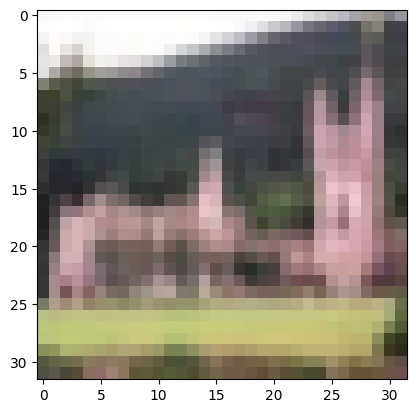

In [71]:
img, label = dataset[31]
plt.imshow(img.permute((1,2,0)))
print('Label as Number:', label)
print('Label as Name:', classes[label])

In [72]:
torch.manual_seed(43)
val_size = 10000
train_size = len(dataset) - val_size

In [73]:
# Random Split and Split of dataset between train and validation.
train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [74]:
batch_size = 128

In [75]:
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory =True)
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory =True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory =True)


Shape of an Image (Batch Size, RGB, Pixels): torch.Size([128, 3, 32, 32])


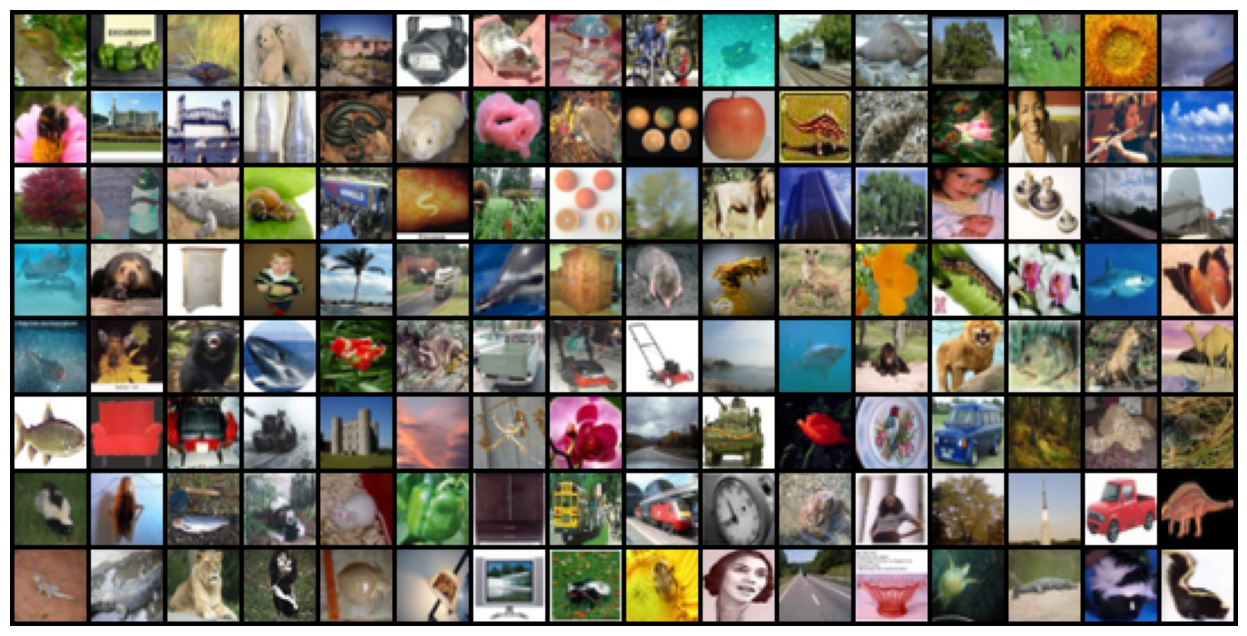

In [76]:
for images, _ in train_loader: 
    print('Shape of an Image (Batch Size, RGB, Pixels):', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0))) 
    break

In [77]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [78]:
device = get_default_device()

In [79]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [80]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [81]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [82]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(),
                                        nn.Dropout(0.25), 
                                        nn.Linear(512, num_classes),
                                        nn.LogSoftmax(dim = 1))
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [83]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)


    model.eval()
    predicted = list()
    actual = list()
    for batch in val_loader:
        outputs = model(batch[0])
        predicted.extend(torch.argmax(outputs, dim=1).tolist())
        actual.extend(batch[1].tolist())

    conf_mat = confusion_matrix(actual, predicted)
    precision = precision_score(actual, predicted, average='macro')
    recall = recall_score(actual, predicted, average='macro')
    F1 = f1_score(actual, predicted, average='macro')
    
    val = [conf_mat,precision,recall,F1]
    key = ['conf_mat','precision','recall','F1']

    for i in range(0,4):
      history[-1][key[i]] = val[i]
    
    return history

In [84]:
from torchvision import models
from torchsummary import summary
model_resnet9 = to_device(ResNet9(3, 100), device)
summary(model_resnet9, input_size = (3, 32, 32), batch_size = 128)
model_resnet9

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 32, 32]           1,792
       BatchNorm2d-2          [128, 64, 32, 32]             128
              ReLU-3          [128, 64, 32, 32]               0
            Conv2d-4         [128, 128, 32, 32]          73,856
       BatchNorm2d-5         [128, 128, 32, 32]             256
              ReLU-6         [128, 128, 32, 32]               0
         MaxPool2d-7         [128, 128, 16, 16]               0
            Conv2d-8         [128, 128, 16, 16]         147,584
       BatchNorm2d-9         [128, 128, 16, 16]             256
             ReLU-10         [128, 128, 16, 16]               0
           Conv2d-11         [128, 128, 16, 16]         147,584
      BatchNorm2d-12         [128, 128, 16, 16]             256
             ReLU-13         [128, 128, 16, 16]               0
           Conv2d-14         [128, 256,

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [85]:
history_resnet9 = [evaluate(model_resnet9, val_loader)]
history_resnet9

[{'val_loss': 4.606240749359131, 'val_acc': 0.010087025351822376}]

In [86]:
no_of_epochs = 100
max_learn_r = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optim_func = torch.optim.Adam

In [87]:
%%time
history_resnet9 += fit_one_cycle(no_of_epochs, max_learn_r, model_resnet9, train_loader, val_loader, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay,  
                             opt_func=optim_func) 

Epoch [0], last_lr: 0.00043, train_loss: 3.9337, val_loss: 3.3578, val_acc: 0.1962
Epoch [1], last_lr: 0.00050, train_loss: 3.0772, val_loss: 2.7929, val_acc: 0.2880
Epoch [2], last_lr: 0.00063, train_loss: 2.5393, val_loss: 2.3478, val_acc: 0.3821
Epoch [3], last_lr: 0.00081, train_loss: 2.1705, val_loss: 2.1482, val_acc: 0.4174
Epoch [4], last_lr: 0.00104, train_loss: 1.9483, val_loss: 2.1936, val_acc: 0.4281
Epoch [5], last_lr: 0.00132, train_loss: 1.7684, val_loss: 2.0184, val_acc: 0.4646
Epoch [6], last_lr: 0.00163, train_loss: 1.6140, val_loss: 2.4785, val_acc: 0.3774
Epoch [7], last_lr: 0.00199, train_loss: 1.4787, val_loss: 2.1082, val_acc: 0.4656
Epoch [8], last_lr: 0.00238, train_loss: 1.3598, val_loss: 2.4990, val_acc: 0.4099
Epoch [9], last_lr: 0.00280, train_loss: 1.2548, val_loss: 1.8496, val_acc: 0.5137
Epoch [10], last_lr: 0.00325, train_loss: 1.1718, val_loss: 2.2087, val_acc: 0.4468
Epoch [11], last_lr: 0.00372, train_loss: 1.1485, val_loss: 2.0419, val_acc: 0.4787
Ep

In [88]:
last = history_resnet9[len(history_resnet9)-1]
precision = last['precision']
recall = last['recall']
F1 = last['F1']

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {F1:.4f}")

Precision: 0.5891
Recall: 0.5885
F1 Score: 0.5867


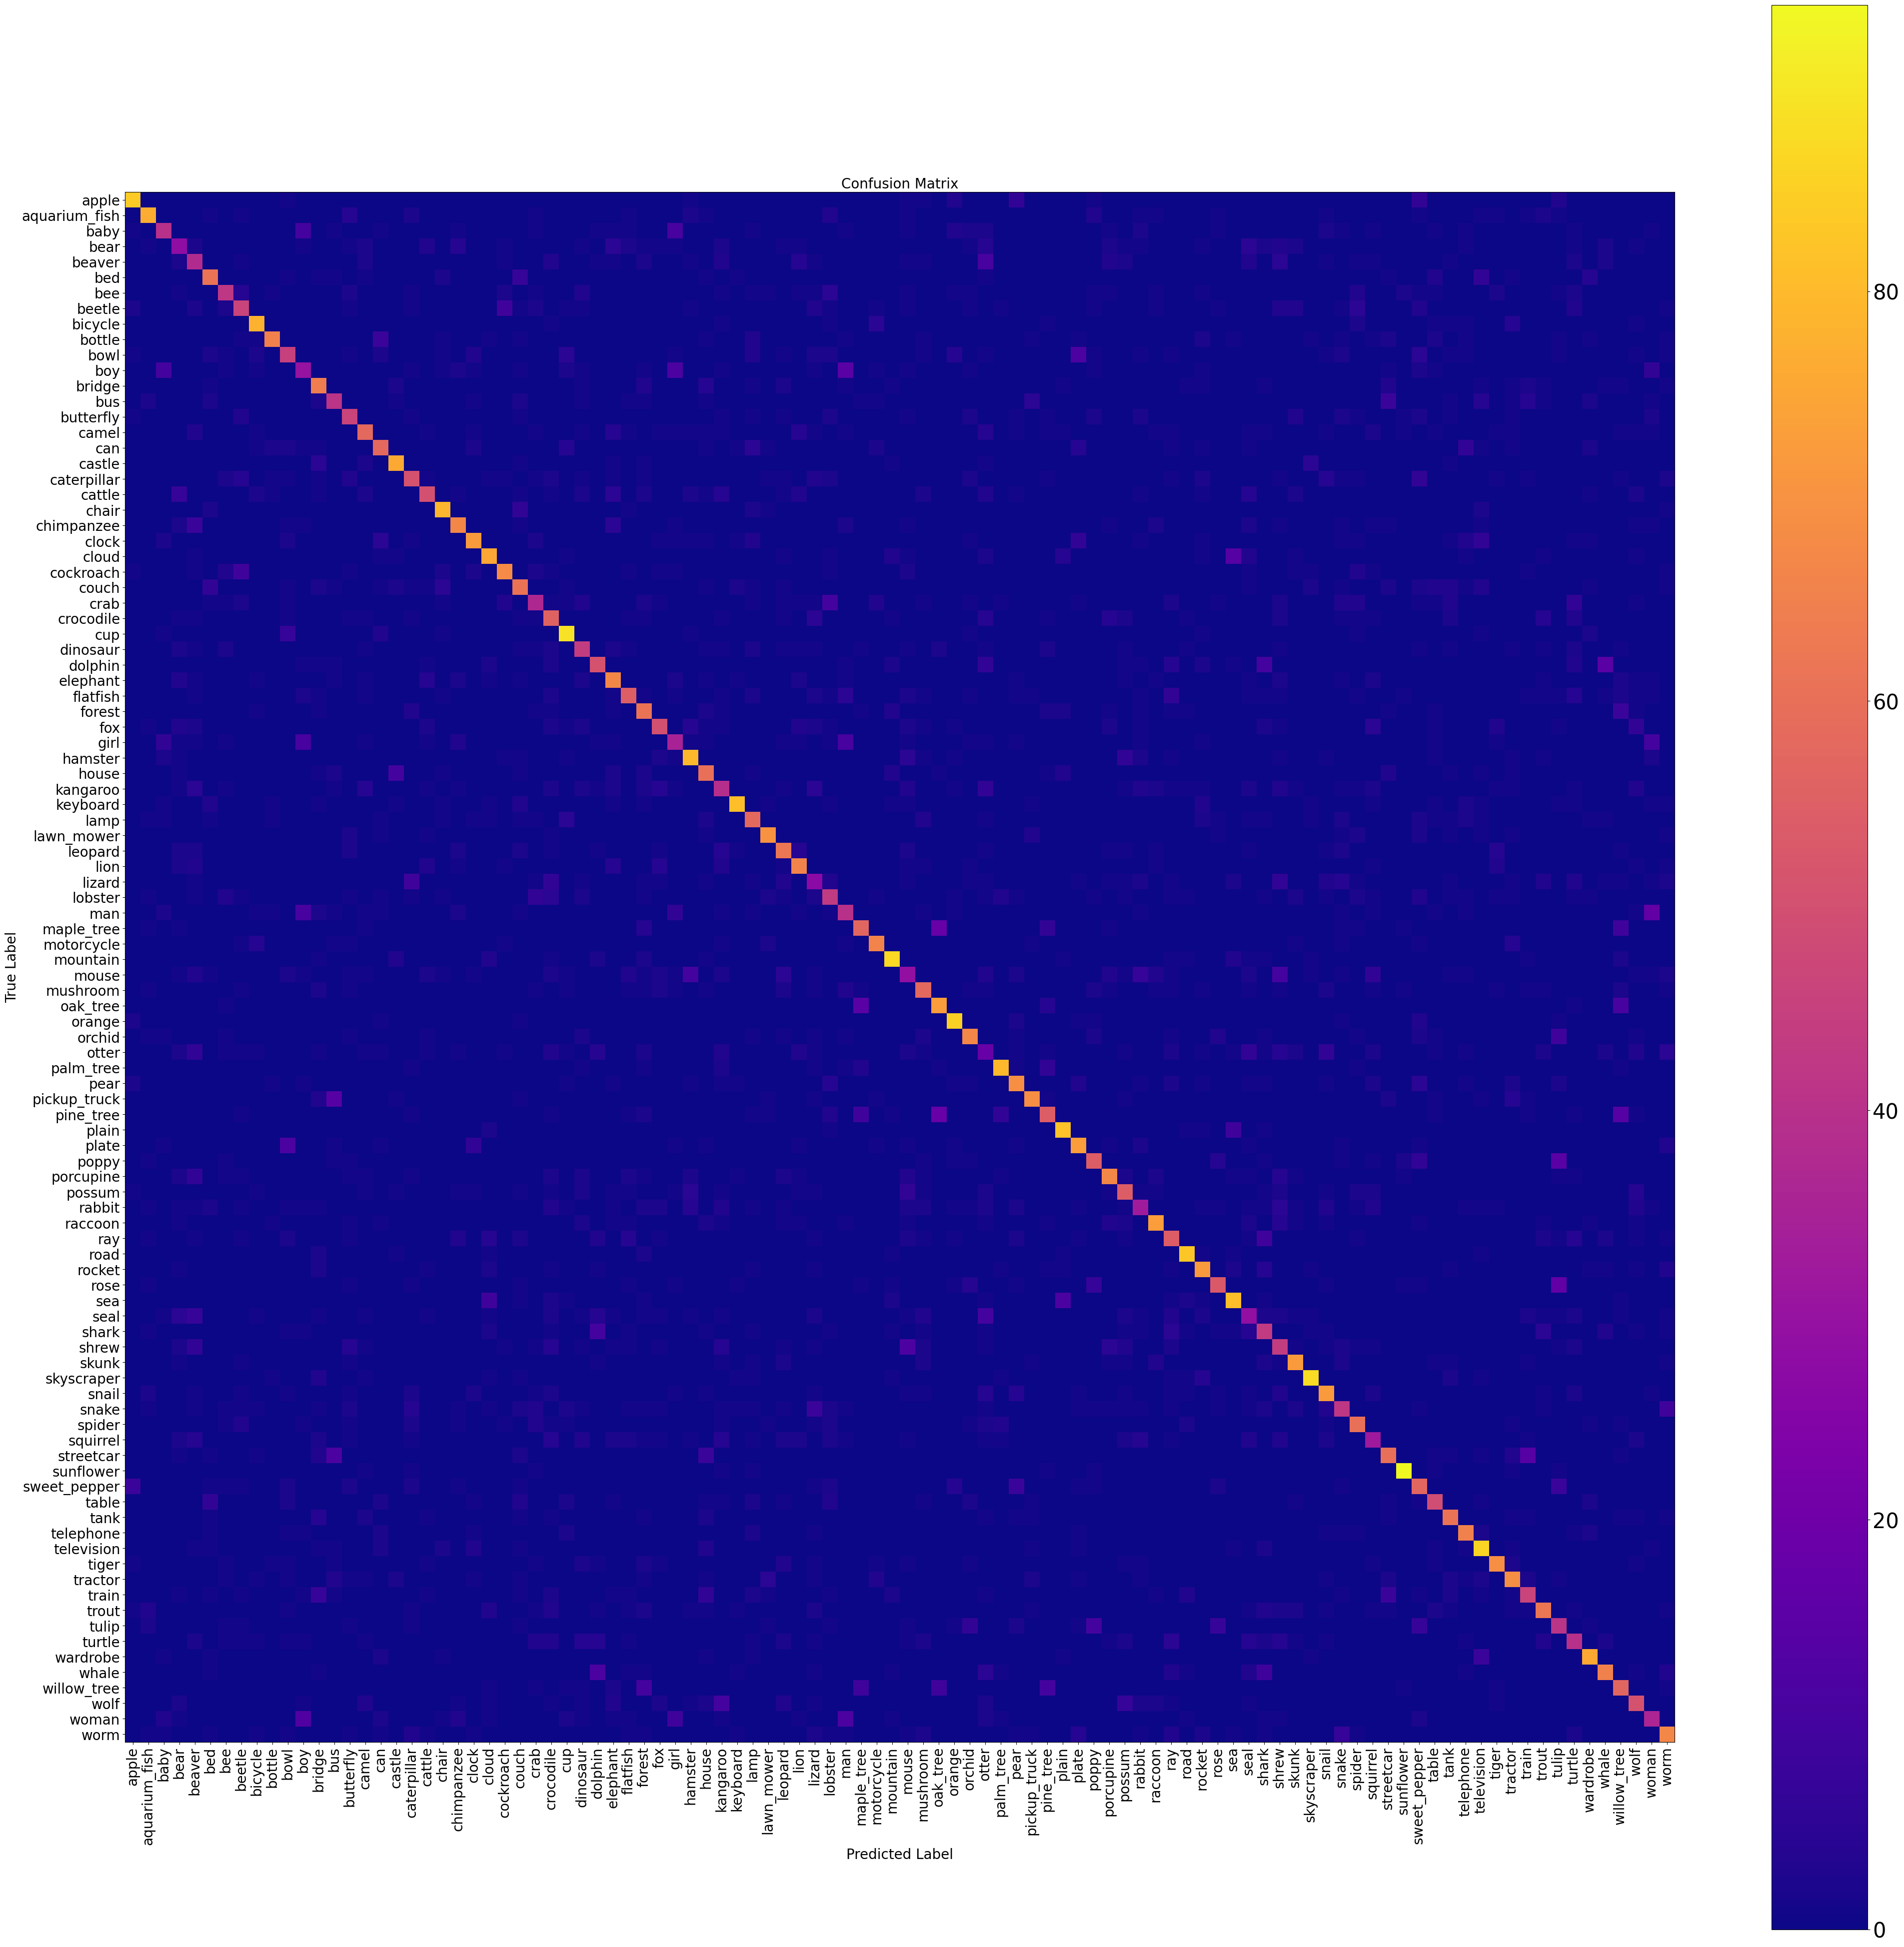

In [89]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(50, 50))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.plasma)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=30)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90,fontsize=20)
    plt.yticks(tick_marks, class_names,fontsize=20)
    plt.xlabel('Predicted Label',fontsize=20)
    plt.ylabel('True Label',fontsize=20)
    plt.title('Confusion Matrix',fontsize=20)
    plt.show()

last = history_resnet9[len(history_resnet9)-1]
conf_mat = last['conf_mat']
plot_confusion_matrix(conf_mat, classes)

In [90]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs');

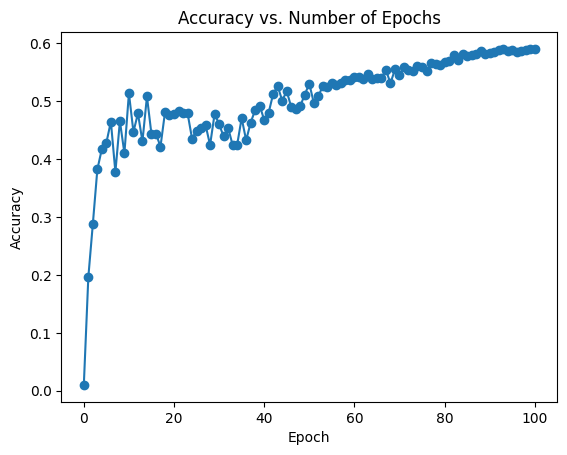

In [91]:
plot_accuracies(history_resnet9)

In [92]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

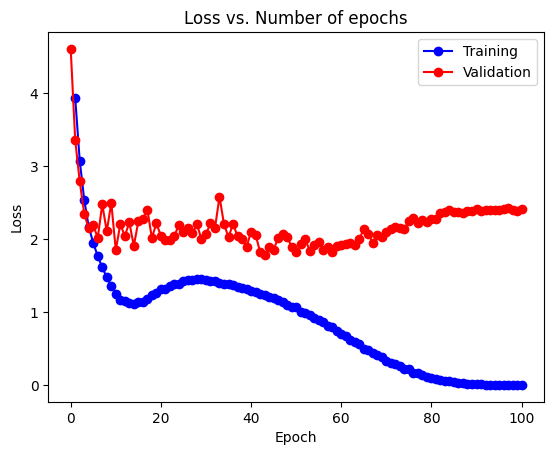

In [93]:
plot_losses(history_resnet9)

In [94]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch Number');

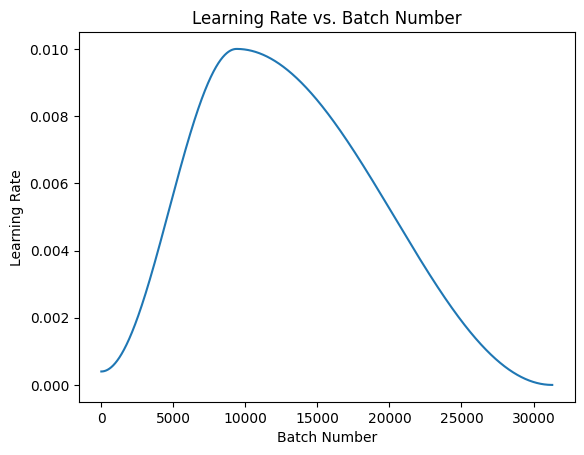

In [95]:
plot_lrs(history_resnet9)

In [96]:
test_resnet9 = evaluate(model_resnet9, test_loader) #final evaluation of resnet9 model with test dataset
test_resnet9

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'val_loss': 2.3913235664367676, 'val_acc': 0.5915743708610535}

In [97]:
test_loss_resnet9 = test_resnet9['val_loss']
test_acc_resnet9 = test_resnet9['val_acc']
print('test_loss_resnet9:', test_resnet9['val_loss'])
print('test_acc_resnet9:', test_resnet9['val_acc'])

test_loss_resnet9: 2.3913235664367676
test_acc_resnet9: 0.5915743708610535


In [98]:
def predict_image(img, model_resnet9):
    xb = to_device(img.unsqueeze(0), device)
    yb = model_resnet9(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: chair , Predicted: chair


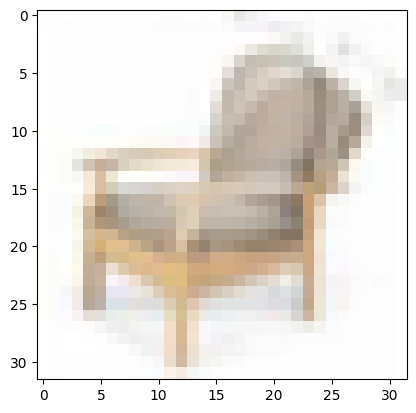

In [100]:
img, label = test_dataset[111]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_resnet9))
